In [3]:
import sys

# Install matplotlib and other core packages into the current Jupyter environment
# We use {sys.executable} to ensure it installs into the correct Python path
!{sys.executable} -m pip install matplotlib seaborn pandas numpy statsmodels pmdarima scikit-learn

print("✅ Attempted to install all necessary packages in the current Jupyter environment.")
print("Please restart your kernel (Kernel -> Restart Kernel...) after this, and then try your imports again.")



  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 39.9 MB/s  0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 45.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]
✅ Attempted to install all necessary packages in the current Jupyter environment.
Please restart your kernel (Kernel -> Restart Kernel...) after this, and then try your imports again.


In [2]:
import sys
import platform
print(f"Python executable in notebook: {sys.executable}")
print(f"Python version in notebook: {sys.version}")

Python executable in notebook: /opt/homebrew/anaconda3/envs/jlab/bin/python
Python version in notebook: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox


In [10]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_ruble_data.csv")
data.columns

Index(['currency_rate', 'date', 'year', 'quarter', 'month', 'day', 'dow',
       'weekend', 'currency_rate_change', 'denomination', 'RUB',
       'GDP_per_capita', 'Brent_price', 'GDP_deflator', 'FD_investment',
       'Inflation'],
      dtype='object')

### Checking stationarity

In [11]:
result = adfuller(data["RUB"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -1.2938804992779436
p-value: 0.6319673214926431
Critical Values: {'1%': -3.431206441353405, '5%': -2.8619184832442954, '10%': -2.56697146213229}


Since the ADF statistic is higher than all critical values, and the p-value is well above 0.05, we fail to reject the null hypothesis of a unit root. This indicates that the RUB time series is non-stationary.
To proceed with time series modeling, let's apply first-order differencing to induce stationarity.

In [12]:
data["RUB_diff"] = data["RUB"].diff()
data[["RUB", "RUB_diff"]].head()

,RUB,RUB_diff
0,0.12526,NaN
1,0.13480,0.00954
2,0.13050,-0.00430
3,0.13030,-0.00020
4,0.13020,-0.00010


In [13]:
result = adfuller(data['RUB_diff'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:", result[4])

ADF Statistic: -15.066128585548803
p-value: 8.860286973543265e-28
Critical Values: {'1%': -3.431206441353405, '5%': -2.8619184832442954, '10%': -2.56697146213229}


Now, since the ADF statistic is much lower than all critical values, and the p-value is effectively 0, we reject the null hypothesis of a unit root. This confirms that the first-differenced RUB series is stationary and suitable for time series modeling.

### ARIMA with 1, 1, 1 without train/test and CV - ARIMA Test

In [22]:
# Fit ARIMA with (p=1, d=1, q=1) as a starting point
model_1 = ARIMA(data["RUB"], order=(1, 1, 1))
model_1_fit = model_1.fit()

print(model_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                 7670
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6882.992
Date:                Tue, 16 Sep 2025   AIC                          13771.985
Time:                        12:11:43   BIC                          13792.820
Sample:                             0   HQIC                         13779.131
                               - 7670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6590      0.015     42.836      0.000       0.629       0.689
ma.L1         -0.5769      0.017    -33.698      0.000      -0.610      -0.543
sigma2         0.3524      0.001    318.998      0.0

I fit an ARIMA(1,1,1) model to the RUB time series. First-order differencing (d=1) was necessary to achieve stationarity, as confirmed by the ADF test. The model suggests that both lagged values (AR term) and past forecast errors (MA term) significantly influence ruble fluctuations. Residual diagnostics indicate no significant autocorrelation, although signs of volatility clustering and heavy tails remain. 

To better capture these dynamics, future improvements could include GARCH models for volatility or ARIMAX models incorporating exogenous variables like Brent crude prices or inflation.

In [15]:
model_2 = auto_arima(data["RUB"], 
                   start_p=0, max_p=5,
                   start_q=0, max_q=5,
                   d=None,              # let auto_arima determine d
                   seasonal=False,      # currency is usually non-seasonal
                   stepwise=True,       # faster search
                   trace=True)          # show search process


print(model_2.summary())

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finit

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13858.385, Time=0.43 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13780.379, Time=0.46 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13781.715, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13858.762, Time=0.08 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13781.784, Time=0.41 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13772.414, Time=1.18 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13767.177, Time=1.55 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13755.703, Time=2.10 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13760.042, Time=0.63 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13757.556, Time=2.68 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13757.170, Time=2.01 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13758.652, Time=1.57 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13759.708, Time=0.47 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13759.078, Time=5.49 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=13755.236, Time=0.68 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13766.708, Time=0.65 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0]             : AIC=13759.747, Time=0.28 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=13757.086, Time=0.83 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=13756.704, Time=0.84 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13781.690, Time=0.18 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=13758.172, Time=0.80 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0]             : AIC=13759.355, Time=0.36 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=13758.606, Time=2.00 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 26.360 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7670
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -6872.618
Date:                Mon, 15 Sep 2025   AIC                          13755.236
Time:                        17:20:12   BIC                          13789.960
Sample:                             0   HQIC                         13767.147
                               - 7670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6063      0.034     18.046      0.000       0.54

Here, using auto_arima, I fit an ARIMA(3,1,1) model to the RUB time series. First-order differencing (d=1) was required to ensure stationarity, as confirmed by the ADF test. 

The model includes 3 autoregressive terms (AR) and 1 moving average term (MA), indicating that the ruble’s current value is influenced by up to three past values and the previous forecast error. All coefficients are statistically significant (p < 0.001), and the residuals show no autocorrelation (Ljung-Box p = 1.00), though heteroskedasticity remains (H = 17.47), suggesting time-varying volatility.

Compared to previous simpler model like ARIMA(1,1,1), this model provides a better fit based on AIC/BIC (13771.985 and 13792.820 vs. 13755.236 and 13789.960), justifying the use of higher AR terms. However, due to the presence of volatility clustering, future improvements may include GARCH models or ARIMAX with macroeconomic exogenous variables (such as Brent oil prices, inflation).


### Create a workset and a holdout sets

In [19]:
data["year"].unique()

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025])

To evaluate the forecasting performance of the ARIMA model on daily RUB exchange rate data and to ensure robustness, I will apply a rolling-origin (expanding window) cross-validation with 4 folds.
So, my prep will be looking: 

Data Setup: 

* Work set: Includes monthly RUB data from 1992 to 2024
* Holdout set: Reserved data for the year 2025 — used for final out-of-sample evaluation


CV Design:

* A test period of 1 full year (daily data)
* A training period of the 13 years (approx. 13 × 365 = ~4,745 days) immediately before the test year


After selecting the best model using cross-validation, I will retrain it on the full work set (1992–2024) and evaluate its performance on the 2025 holdout set.


In [20]:
data_holdout = data.loc[lambda x: x["year"] == 2025, :]
data_work = data.loc[lambda x: x["year"] < 2025, :]

In [27]:
# Rolling origin CV
for year in range(2021, 2025):  # have data from 1992–2024
    fold = year - 2020          # fold1 = 2021, ..., fold4 = 2024
    data_work["test" + str(fold)] = data_work["year"] == year
    data_work["train" + str(fold)] = (data_work["year"] <= year - 1) & (data_work["year"] >= year - 13)

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/3631020280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work["test" + str(fold)] = data_work["year"] == year
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/3631020280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work["train" + str(fold)] = (data_work["year"] <= year - 1) & (data_work["year"] >= year - 13)


#### Visualisation of Training and Test Sets:

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/1830224871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work["test" + str(fold)] = data_work["year"] == year
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/1830224871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work["train" + str(fold)] = (data_work["year"] <= year - 1) & (data_work["year"] >= year - 13)


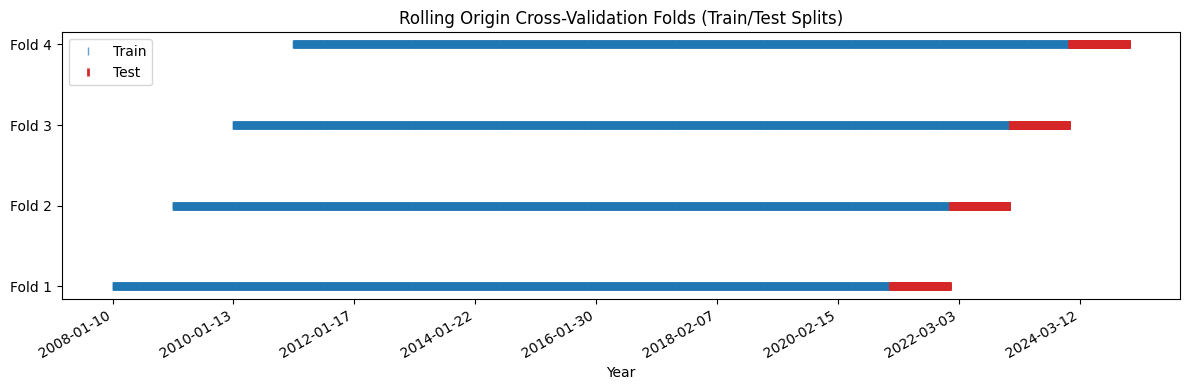

In [40]:
for year in range(2021, 2025):  # have data from 1992–2024
    fold = year - 2020
    data_work["test" + str(fold)] = data_work["year"] == year
    data_work["train" + str(fold)] = (data_work["year"] <= year - 1) & (data_work["year"] >= year - 13)


fig, ax = plt.subplots(figsize=(12, 4))

for fold in range(1, 5):
    train_mask = data_work["train" + str(fold)]
    test_mask = data_work["test" + str(fold)]

    ax.plot(data_work.loc[train_mask, "date"], [fold]*train_mask.sum(), 
            '|', color='tab:blue', label="Train" if fold == 1 else "", alpha=0.7)

    ax.plot(data_work.loc[test_mask, "date"], [fold]*test_mask.sum(), 
            '|', color='tab:red', label="Test" if fold == 1 else "", markeredgewidth=2)

ax.set_yticks(range(1, 5))
ax.set_yticklabels([f"Fold {i}" for i in range(1, 5)])
ax.set_xlabel("Year")
ax.set_title("Rolling Origin Cross-Validation Folds (Train/Test Splits)")
ax.legend(loc='upper left')
# Format x-axis to show years
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

#### Auto_ARIMA

In [45]:
# 0. Convert date column to datetime index
data_work['date'] = pd.to_datetime(data_work['date'])
data_work.set_index('date', inplace=True)

# 1. Auto_arima
model_3 = auto_arima(data_work["RUB"], 
                     start_p=0, max_p=5,
                     start_q=0, max_q=5,
                     d=None,              # let auto_arima determine d
                     seasonal=False,      # currency is usually non-seasonal
                     stepwise=True,       # faster search
                     trace=True)          # show search process

# 2. Extract best order (p, d, q)
best_order = model_3.order
print("Best ARIMA order:", best_order)

# 3. Cross-validation with 4 folds
mse_2 = []

for i in range(1, 5):
    # Create masks
    train_mask = data_work["train" + str(i)] == True
    test_mask  = data_work["test"  + str(i)] == True

    # Get y_train and y_test
    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    # Fit model on training data
    model = ARIMA(endog=y_train, order=best_order).fit()

    # Forecast exactly len(test) steps
    phat = model.forecast(steps=len(y_test))

    # Compute squared error
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

# 4. Final RMSE
rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)
print(acorr_ljungbox(model.resid, lags=[10], return_df=True))

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/525131746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work['date'] = pd.to_datetime(data_work['date'])  # if not already datetime
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13427.443, Time=0.19 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13356.033, Time=0.36 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13358.027, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13429.364, Time=0.05 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13356.403, Time=0.37 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13344.285, Time=0.69 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13341.402, Time=1.62 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13332.336, Time=1.12 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13333.160, Time=0.36 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13333.468, Time=2.09 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13333.000, Time=1.94 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13334.519, Time=1.60 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13334.200, Time=0.47 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13334.945, Time=2.73 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=13332.916, Time=0.91 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 14.871 seconds
Best ARIMA order: (3, 1, 1)


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

CV RMSE (Auto ARIMA): 12.043861120582255
     lb_stat  lb_pvalue
10  3.358403   0.971689


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [48]:
best_order = model_3.order
rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("Best ARIMA order:", best_order)
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)
print(acorr_ljungbox(model.resid, lags=[10], return_df=True))

Best ARIMA order: (3, 1, 1)
CV RMSE (Auto ARIMA): 12.043861120582255
     lb_stat  lb_pvalue
10  3.358403   0.971689


After applying Auto ARIMA to model daily RUB exchange rate data, the best-fitting model identified was ARIMA(3,1,1). This means the series required one level of differencing to achieve stationarity, and both autoregressive and moving average components of order 3 and 1, respectively, contributed meaningfully to capturing the underlying dynamics.

To ensure robustness, I implemented a **rolling-origin cross-validation** with four folds (2021–2024), gradually expanding the training window and testing performance year by year. The cross-validated **RMSE was approximately 12.04**, indicating a reasonably good predictive performance for such a volatile macroeconomic variable.

Additionally, the **Ljung–Box test** at lag 10 produced a high p-value (~0.97), suggesting that the residuals of the fitted model do not exhibit significant autocorrelation — a desirable property that supports the validity of the model.

While ARIMA(3,1,1) provides a solid univariate forecasting baseline, future enhancements could include:

- **ARIMAX**, to incorporate exogenous drivers like oil prices, inflation, or interest rates.
- **GARCH models**, to capture volatility clustering common in financial time series.
- **VAR models**, if expanding to multivariate analysis.

Overall, this ARIMA model establishes a strong foundation for modeling RUB dynamics and sets the stage for deeper, more nuanced time series analysis.